# Neural Nets (Sigmoid)
In this exercise we will be implementing a two-layer neural net that will classify between digits in the MNIST dataset. We will be using its training data to train our neural net and we will report the best possible classification performance in the held-out test images.

In [11]:
# some startup
import numpy as np
import src.data_utils as util
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def get_MNIST_data(num_training=50000, num_validation=10000):
    path_to_dataset = 'data/datasets'

    # load raw MNIST data
    # https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py
    X_train, y_train = util.load_mnist('training', path=path_to_dataset, return_labels=True)
    X_test, y_test = util.load_mnist('testing', path=path_to_dataset, return_labels=True)
    
    # subsample training data to training and validation data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]

    # reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    
    # No 'bias trick' needed here. Our NN already has bias params.

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_MNIST_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


# Training
Here we'll be tuning our hyperparameters (learning rates, regularization strengths, and hidden layer sizes) by training our two-layer neural network multiple times on the validation set and reporting the results. The combination of hyperparameters that gives the highest validation accuracy are the ones we will choose.

In [13]:
# Visualize the weights of the network

def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(28, 28, -1).transpose(2, 0, 1)
  plt.imshow(util.visualize_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

If you want to skip the training step (after this code cell), you can just directly load the pre-trained model by executing this code cell.

In [21]:
import dill
with open('data/pretrained/best_neuralnetsigmoid.pkl', 'rb') as f:
    best_net = dill.load(f)

epoch (1 / 20): loss: 0.068370 train acc: 0.900000 val acc: 0.911600 lr: 0.700000
epoch (2 / 20): loss: 0.066307 train acc: 0.890000 val acc: 0.923800 lr: 0.700000
epoch (3 / 20): loss: 0.049331 train acc: 0.940000 val acc: 0.934600 lr: 0.630000
epoch (4 / 20): loss: 0.035138 train acc: 0.955000 val acc: 0.941000 lr: 0.630000
epoch (5 / 20): loss: 0.047066 train acc: 0.935000 val acc: 0.950100 lr: 0.567000
epoch (6 / 20): loss: 0.049450 train acc: 0.935000 val acc: 0.953000 lr: 0.567000
epoch (7 / 20): loss: 0.023848 train acc: 0.970000 val acc: 0.955700 lr: 0.510300
epoch (8 / 20): loss: 0.035910 train acc: 0.945000 val acc: 0.960200 lr: 0.510300
epoch (9 / 20): loss: 0.043461 train acc: 0.940000 val acc: 0.960800 lr: 0.459270
epoch (10 / 20): loss: 0.025919 train acc: 0.960000 val acc: 0.963900 lr: 0.459270
epoch (11 / 20): loss: 0.027792 train acc: 0.960000 val acc: 0.965200 lr: 0.413343
epoch (12 / 20): loss: 0.032333 train acc: 0.960000 val acc: 0.965600 lr: 0.413343
epoch (13 / 2

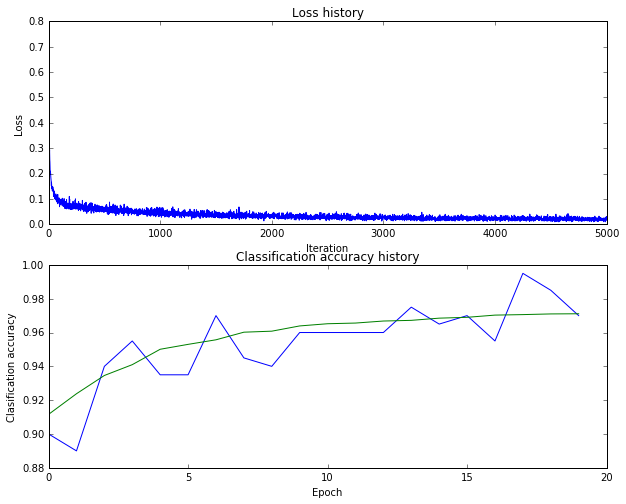

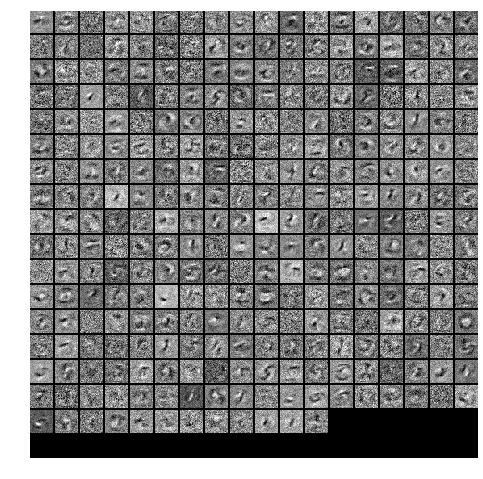

lr 7.000000e-01 reg 0.000000e+00 sz 3.000000e+02 train accuracy: 0.974160 val accuracy: 0.971100
best validation accuracy achieved during cross-validation: 0.971100


In [19]:
input_size = X_train.shape[1]
num_classes = 10  # 10 digits to classify

# cross-validation on multiple learning rates and regularization
# strengths.
from src.classifiers import TwoLayerNetSigmoid
results = {}
best_net = None
best_val = -1
learning_rates = [7e-1, 5e-1, 1e-1]
regularization_strengths = [0, 1e-3, 5e-4] # 1e-3 gives smoother filters
hidden_layer_sizes = [30, 100, 300]

for rate in learning_rates:
    for strength in regularization_strengths:
        for hidden_size in hidden_layer_sizes:
            net = TwoLayerNetSigmoid(input_size, hidden_size, num_classes, std='msra')

            # Train the network
            stats = net.train(X_train, y_train, X_val, y_val,
                        num_iters=5000, batch_size=200,
                        learning_rate=rate, learning_rate_decay=0.90,
                        momentum='Nesterov', reg=strength, verbose=True)

            # Predict on the validation set and training set
            val_acc = (net.predict(X_val) == y_val).mean()
            print 'Validation accuracy: ', val_acc
            train_acc = (net.predict(X_train) == y_train).mean()
            print 'Training accuracy: ', train_acc

            # Plot the loss function and train / validation accuracies
            plt.subplot(2, 1, 1)
            plt.plot(stats['loss_history'])
            plt.title('Loss history')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')

            plt.subplot(2, 1, 2)
            plt.plot(stats['train_acc_history'], label='train')
            plt.plot(stats['val_acc_history'], label='val')
            plt.title('Classification accuracy history')
            plt.xlabel('Epoch')
            plt.ylabel('Clasification accuracy')
            plt.show()

            show_net_weights(net)
            
            results[(rate, strength, hidden_size)] = train_acc, val_acc
            
            if val_acc > best_val:
                best_val = val_acc
                best_net = net

# Print out results.
for lr, reg, sz in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, sz)]
    print 'lr %e reg %e sz %e train accuracy: %f val accuracy: %f' % (
                lr, reg, sz, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

Let's report the final test set accuracy. We'll also output a precision-recall summary and a confusion matrix.

In [22]:
# evaluate the best net on test set
y_test_pred = best_net.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print '2-layer nn on raw pixels final test set accuracy: %f' % (test_accuracy, )
print

# Import datasets, classifiers and performance metrics
from sklearn import metrics

print("Classification report for classifier %s:\n%s\n"
      % (best_net, metrics.classification_report(y_test, y_test_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_test_pred))

2-layer nn on raw pixels final test set accuracy: 0.968200

Classification report for classifier <src.classifiers.neural_net_sigmoid.TwoLayerNetSigmoid object at 0x114e51dd0>:
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       980
          1       0.98      0.99      0.98      1135
          2       0.97      0.97      0.97      1032
          3       0.96      0.97      0.97      1010
          4       0.96      0.97      0.97       982
          5       0.97      0.96      0.96       892
          6       0.97      0.97      0.97       958
          7       0.97      0.96      0.96      1028
          8       0.97      0.97      0.97       974
          9       0.96      0.94      0.95      1009

avg / total       0.97      0.97      0.97     10000


Confusion matrix:
[[ 964    0    0    2    0    3    6    1    2    2]
 [   0 1121    2    2    0    1    5    1    3    0]
 [   5    1 1000    3    6    0    3    9    5    0]
 [   0 

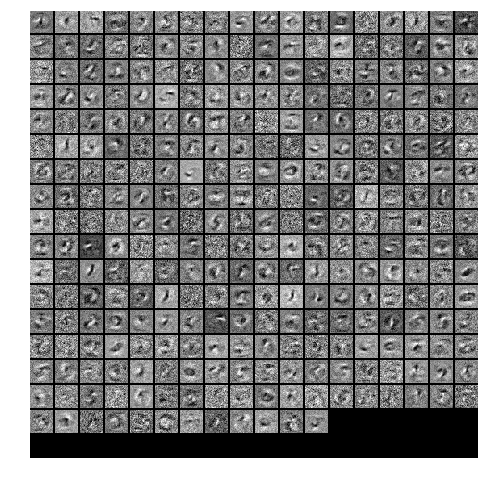

In [7]:
# visualize the weights of the best network
show_net_weights(best_net)